In [1]:
import math
import numpy as np
import pandas as pd
import sklearn
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [2]:
df = pd.read_csv(path,delimiter="\x01")

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3170: DtypeWarning: Columns (0,4,5,6,8,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data exploration / cleaning

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 644089 entries, 0 to 644088
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   restaurant_id      644089 non-null  object 
 1   name               644086 non-null  object 
 2   platform           644087 non-null  object 
 3   sub_platform       599311 non-null  object 
 4   latitude           644086 non-null  object 
 5   longitude          644070 non-null  object 
 6   city               56196 non-null   object 
 7   country            644071 non-null  object 
 8   active             643867 non-null  object 
 9   standardized_name  643872 non-null  object 
 10  restaurant_chain   169 non-null     object 
 11  delivery_radius    354661 non-null  object 
 12  geom               0 non-null       float64
dtypes: float64(1), object(12)
memory usage: 63.9+ MB


None

In [5]:
cols = [i for i in df.columns]
for c in cols:
    print (c + ' contains ' + str(len(df[c].unique())) + ' unique values')

restaurant_id contains 610625 unique values
name contains 419801 unique values
platform contains 47 unique values
sub_platform contains 31 unique values
latitude contains 572056 unique values
longitude contains 570051 unique values
city contains 3061 unique values
country contains 28 unique values
active contains 33 unique values
standardized_name contains 410993 unique values
restaurant_chain contains 36 unique values
delivery_radius contains 913 unique values
geom contains 1 unique values


In [ ]:
# data cleaning
platforms_list = ['caviar','delivery.com','doordash','grubhub','postmates','ubereats']

df_clean = df[df['platform'].isin(platforms_list) == True].copy()
df_clean['latitude'] = pd.to_numeric(df_clean['latitude'], errors='coerce')
df_clean['longitude'] = pd.to_numeric(df_clean['longitude'], errors='coerce')

# filter non-active restaurants
df_clean = df_clean[(df_clean['active'] == True) | (df_clean['active'] == 'TRUE')]

# filter out of range coordinates
df_clean = df_clean[df_clean['latitude'].between(-90, 90)]
df_clean = df_clean[df_clean['longitude'].between(-180, 180)]
df_clean = df_clean.sort_values(['latitude', 'longitude'],ascending = [True, True]).reset_index(drop=True)
# df_clean = df_clean.dropna(subset=['latitude', 'longitude'], how='any').reset_index(drop=True)

df_clean

In [8]:
print (str(len(df) - len(df_clean)) + ' records have been droppped')

75286 records have been droppped


In [9]:
display(df_clean.describe())

,latitude,longitude,geom
count,568803.000000,568803.000000,0.0
mean,37.338202,-94.187933,NaN
std,5.365668,18.325213,NaN
min,18.375054,-158.125756,NaN
25%,33.762216,-116.237673,NaN
50%,38.553986,-87.762132,NaN
75%,40.798910,-77.512947,NaN
max,61.169066,-65.722797,NaN


### nGrams

In [ ]:
# stardardize restaurant names

import string
import re 
    
def remove_punct(text):
    text_nopunct=''.join([char for char in text if char not in string.punctuation])
    return text_nopunct.lower()

def remove_brackets(text):
    return re.sub(r'\([^)]*\)', "", text)

def remove_special(text):
    return re.sub(r'\W+', ' ', text)

def remove_trailing_spaces(text):
    return text.strip()

def ngrams(string, n=2):
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

df_clean['name'] = df_clean['name'].astype(str)
df_clean['name_clean']=df_clean['name'].apply(lambda x: remove_brackets(x))
df_clean['name_clean']=df_clean['name_clean'].apply(lambda x: remove_special(x))
df_clean['name_clean']=df_clean['name_clean'].apply(lambda x: remove_punct(x))
df_clean['name_clean']=df_clean['name_clean'].apply(lambda x: remove_trailing_spaces(x))

df_clean

#### TF-IDF

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# After tokenization Tfidfvectorizer convert documents to a matrix of TF-IDF features. 
# Generate the matrix of TF-IDF (Term Frequency-Inverse Document frequency) values

names = df_clean['name_clean']
vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(names)

In [15]:
tf_idf_matrix.shape

(568803, 1150)

### Data segmentation / indexing


We will also split all data into geographic segment using Latitude and Longitude, and only compute similarity for restaurants within the same segment, this will significantly increase the efficiency of matrix operations


In [16]:
# geographic segmentation 

geo_segment_index = []
geo_segment_matrices = []

for lat in range(-90,90,1):
    for lon in range(-180,180,1):
        idx_list = df_clean.index[(df_clean['latitude']>=lat) & (df_clean['latitude']<lat+1) & (df_clean['longitude']>=lon) & (df_clean['longitude']<lon+1)].to_list()
        
        if len(idx_list) > 10000:
            i = 0
            while i < len(idx_list):
                geo_segment_index.append(idx_list[i:i+10000])
                i += 10000
        else:
            geo_segment_index.append(idx_list)

for i in geo_segment_index:
    geo_segment_matrices.append(tf_idf_matrix[i,:])        
        
print (str(sum([len(l) for l in geo_segment_index])) + " indices have been mapped")

568803 indices have been mapped


In [ ]:
# check output matrices
check_matrix = [m.shape[0] for m in geo_segment_matrices]
check_matrix.sort(reverse = True)
check_matrix

### Cos similarity

In [18]:
import sparse_dot_topn.sparse_dot_topn as ct
from scipy.sparse import csr_matrix

def cossim_top_n(Mat1, Mat2, ntop, lower_bound=0):
    if Mat1.shape[0] == 0 or Mat2.shape[0] == 0:
        return None
    
    else:
        Mat2 = Mat2.transpose()

        Mat1 = Mat1.tocsr()
        Mat2 = Mat2.tocsr()
        M, _ = Mat1.shape
        _, N = Mat2.shape

        idx_dtype = np.int32

        nnz_max = M*ntop

        indptr = np.zeros(M+1, dtype=idx_dtype)
        indices = np.zeros(nnz_max, dtype=idx_dtype)
        data = np.zeros(nnz_max, dtype=Mat1.dtype)

        ct.sparse_dot_topn(
            M, N, np.asarray(Mat1.indptr, dtype=idx_dtype),
            np.asarray(Mat1.indices, dtype=idx_dtype),
            Mat1.data,
            np.asarray(Mat2.indptr, dtype=idx_dtype),
            np.asarray(Mat2.indices, dtype=idx_dtype),
            Mat2.data,
            ntop,
            lower_bound,
            indptr, indices, data)

        return csr_matrix((data,indices,indptr),shape=(M,N))

In [19]:
# unpacks the resulting sparse matrix

def get_matches_df(sparse_matrix, left_indices, right_indices, orig_data, top=None):
    non_zeros = sparse_matrix.nonzero()
    
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]
    
    if top:
        nr_matches = top
    else:
        nr_matches = sparsecols.size
    
    left_index = np.empty([nr_matches], dtype=object)
    left_name = np.empty([nr_matches], dtype=object)    
    right_index = np.empty([nr_matches], dtype=object)
    right_name = np.empty([nr_matches], dtype=object)   
    similairity = np.zeros(nr_matches)
    
    for i in range(0, nr_matches):
        left_index[i] = left_indices[sparserows[i]]
        left_name[i] = df_clean.iloc[left_indices[sparserows[i]]]['name']        
        right_index[i] = right_indices[sparsecols[i]]
        right_name[i] = df_clean.iloc[right_indices[sparsecols[i]]]['name']
        similairity[i] = sparse_matrix.data[i]
    
    return pd.DataFrame({'left_index': left_index,
                         'left_side_name': left_name,
                          'right_index': right_index,
                         'right_side_name': right_name,
                           'similairity': similairity})

In [20]:
# iterate through all combination of platform segments, store output in a dictionary
# keep up to top 500 matches for each restaurant
matches_list = []
for i in range(len(geo_segment_matrices)):
    matches_list.append(cossim_top_n(geo_segment_matrices[i], geo_segment_matrices[i], 500, 0.8))

In [ ]:
# use original indices to recover correct restaurant names
matches_df_list = []

for i in range(len(matches_list)):
    if matches_list[i] != None:
        matches_df_list.append(get_matches_df(matches_list[i], geo_segment_index[i], geo_segment_index[i], df_clean))
    if i % 50 == 0:
        print (str(i) + ' matrices processed')

In [22]:
# concatenate all output df to single df
matches_df = pd.concat(matches_df_list)
matches_df

,left_index,left_side_name,right_index,right_side_name,similairity
0,0,EcoRican Cafe,0,EcoRican Cafe,1.000000
0,1,Benedetti's Picacho Ajusco,1,Benedetti's Picacho Ajusco,1.000000
1,2,Fonda Argentina,686,Fonda Argentina,1.000000
2,2,Fonda Argentina,243,Fonda Argentina,1.000000
3,2,Fonda Argentina,20,Fonda Argentina,1.000000
...,...,...,...,...,...
101,568799,Roti Test Store,568799,Roti Test Store,1.000000
102,568799,Roti Test Store,568789,Roti Test Store Corner,0.844202
103,568800,Buca di Beppo+ (testy testy),568800,Buca di Beppo+ (testy testy),1.000000
104,568801,My God There's Maple Everywhere,568801,My God There's Maple Everywhere,1.000000


In [23]:
# join with original df to collect location information
final_df = matches_df.merge(df_clean[['latitude','longitude','platform','name_clean']], how='left', left_on='left_index', right_index=True)
final_df = final_df.rename(columns={"latitude": "left_latitude", "longitude": "left_longitude", "platform": "left_platform"})
final_df = final_df.merge(df_clean[['latitude','longitude','platform']], how='left', left_on='right_index', right_index=True)
final_df = final_df.rename(columns={"latitude": "right_latitude", "longitude": "right_longitude", "platform": "right_platform"})

# remove duplicate matches and matches between same platform
final_df = final_df[~(final_df['left_platform'] == final_df['right_platform'])]

reverse_platforms = platforms_list[::-1]
for i in range(len(reverse_platforms)):
    for j in range(i+1,len(reverse_platforms)):
        final_df = final_df[~((final_df['left_platform'] == reverse_platforms[i]) & (final_df['right_platform'] == reverse_platforms[j]))]
final_df


,left_index,left_side_name,right_index,right_side_name,similairity,left_latitude,left_longitude,left_platform,name_clean,right_latitude,right_longitude,right_platform
22,1856,McDonald's (91-919 Ft Weaver Rd),2327,McDonald's�� (94-595 KAPUOHI ST),1.0,21.317670,-158.013903,doordash,mcdonald s,21.391370,-158.034436,ubereats
26,1856,McDonald's (91-919 Ft Weaver Rd),2094,McDonald's�� (91-590 FARRINGTON HWY),1.0,21.317670,-158.013903,doordash,mcdonald s,21.339842,-158.077026,ubereats
29,1856,McDonald's (91-919 Ft Weaver Rd),1972,McDonald's�� (4600 KAPOLEI PARKWAY),1.0,21.317670,-158.013903,doordash,mcdonald s,21.328431,-158.087860,ubereats
31,1856,McDonald's (91-919 Ft Weaver Rd),1857,McDonald's�� (91-919 FT WEAVER ROAD),1.0,21.317670,-158.013903,doordash,mcdonald s,21.317707,-158.013887,ubereats
66,1945,Teddy's Bigger Burgers,1976,Teddy's Bigger Burgers (Kapolei),1.0,21.326239,-158.021310,doordash,teddy s bigger burgers,21.329398,-158.078405,ubereats
...,...,...,...,...,...,...,...,...,...,...,...,...
722,559811,India Grill,559812,India Grill,1.0,48.749432,-122.480194,grubhub,india grill,48.749432,-122.480194,ubereats
757,559821,Over Easy,559820,Over Easy,1.0,48.762375,-122.463966,grubhub,over easy,48.762370,-122.464899,ubereats
759,559822,Pita Pit,559819,Pita Pit (2426 James Street),1.0,48.762402,-122.463989,grubhub,pita pit,48.762310,-122.464898,ubereats
760,559822,Pita Pit,559809,Pita Pit (Holly St),1.0,48.762402,-122.463989,grubhub,pita pit,48.749029,-122.477684,ubereats


### Compute Geolocation distance

In [24]:
def Haversine_distance(lat1, lon1, lat2, lon2):
    from math import sin, cos, sqrt, atan2, radians

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [25]:
distances_km = []
for row in final_df.itertuples(index=False):
    distances_km.append(
       Haversine_distance(row.left_latitude, row.left_longitude, row.right_latitude, row.right_longitude)
   )

In [26]:
# assume maximum error for restaurant coordinates within 0.1km
final_df['distance'] = distances_km
output = final_df[final_df['distance'] < 0.05]
output

,left_index,left_side_name,right_index,right_side_name,similairity,left_latitude,left_longitude,left_platform,name_clean,right_latitude,right_longitude,right_platform,distance
31,1856,McDonald's (91-919 Ft Weaver Rd),1857,McDonald's�� (91-919 FT WEAVER ROAD),1.000000,21.317670,-158.013903,doordash,mcdonald s,21.317707,-158.013887,ubereats,0.004476
68,1945,Teddy's Bigger Burgers,1944,Teddy's Bigger Burgers (Ewa Beach),1.000000,21.326239,-158.021310,doordash,teddy s bigger burgers,21.326239,-158.021310,ubereats,0.000059
217,2072,Teapresso Bar,2070,Teapresso Bar (Farrington Hwy),1.000000,21.336916,-158.078725,doordash,teapresso bar,21.336895,-158.078775,ubereats,0.005707
432,2325,McDonald's (94-595 Kapuohi St),2327,McDonald's�� (94-595 KAPUOHI ST),1.000000,21.391242,-158.034503,doordash,mcdonald s,21.391370,-158.034436,ubereats,0.015872
29,782,The Coffee Bean & Tea Leaf (Monsarrat Ave),781,The Coffee Bean & Tea Leaf,1.000000,21.269878,-157.811174,doordash,the coffee bean tea leaf,21.269791,-157.811203,postmates,0.010160
...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,559803,Papa John's Pizza,559802,Papa John's (1306 Lakeway Dr),0.876507,48.744587,-122.458061,grubhub,papa john s pizza,48.744586,-122.458064,ubereats,0.000230
706,559807,The Pita Pit,559810,The Pita Pit,1.000000,48.748720,-122.477557,delivery.com,the pita pit,48.749031,-122.477684,grubhub,0.035831
710,559807,The Pita Pit,559809,Pita Pit (Holly St),0.884482,48.748720,-122.477557,delivery.com,the pita pit,48.749029,-122.477684,ubereats,0.035610
721,559810,The Pita Pit,559809,Pita Pit (Holly St),0.884482,48.749031,-122.477684,grubhub,the pita pit,48.749029,-122.477684,ubereats,0.000229


### Results & Summary

In [28]:
output.groupby('left_index').agg(duplicates=('right_index', 'count')).reset_index().sort_values('duplicates')

,left_index,duplicates
0,782,1
78783,328172,1
78782,328164,1
78780,328157,1
78779,328141,1
...,...,...
100179,419043,6
118135,500228,7
117282,497009,7
117778,498765,8


The matching algorithm have found 127354 restaurants with duplicate records in the dataset, with 166417 records in total.

After deduping, there are about 402386 distinct active restaurants left in the dataset.

The algorithm consists of the following steps:
1. Data cleaning and filtering
2. Name cleaning and standardization
3. Segmentation/indexing using coordinate information
4. nGrams and TF-IDF to convert names to word vectors
5. Cos-similarity to iteratively compute similarity between names and filter out names with high similarity
6. Compute Haversine distance and filter out restaurants with close proximity
7. Remove duplicate results from all combinations between platforms


### Platform coverage for top restaurants

In [ ]:
# statistics, distribution plot of duplicate records
# calculate restaurant's platform coverage using number of duplicate records in the dataset vs number of total records
total_restaurants = df_clean.groupby('name_clean').agg(total_restaurants=('restaurant_id', 'count')).reset_index().sort_values('total_restaurants',ascending=False)
total_duplicate_records = output.groupby('name_clean').agg(total_duplicates=('right_index', 'count')).sort_values('total_duplicates',ascending=False)

platform_coverage = total_restaurants.merge(total_duplicate_records, how='left', left_on='name_clean', right_on='name_clean')
platform_coverage = platform_coverage.fillna(0)
platform_coverage['actual_restaurants'] = platform_coverage['total_restaurants'] - platform_coverage['total_duplicates']

platform_coverage = platform_coverage[platform_coverage['actual_restaurants'] > 0]
platform_coverage['platform_coverage'] = platform_coverage['total_restaurants']/platform_coverage['actual_restaurants']
platform_coverage = platform_coverage.sort_values('total_restaurants', ascending=False).reset_index(drop=True)

platform_coverage.head(10)

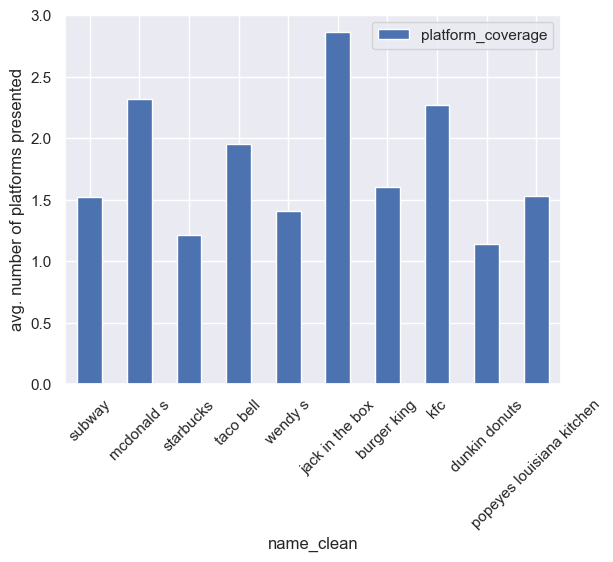

In [30]:
test = platform_coverage.head(10)
ax = test.plot.bar(x='name_clean',y='platform_coverage', rot=45)
plt.ylabel('avg. number of platforms presented')
plt.show()
plt.clf()

Through above steps, I filtered out top 10 popular restaurants and analyze their platform coverage (i.e. average number of platforms restaurant lists in). It is noted that Jack in the Box and Mcdonalds are listed on the most platforms, with an average of 2.86 and 2.32 platforms. The least listed restaurants are Starbucks and Dunkin Donuts, with an average of 1.21 and 1.14 platforms.

### Average platform coverage by restaurant size

In [ ]:
l = len(platform_coverage)

platform_coverage['decile'] = ((platform_coverage.index/l) // 0.1)+1
platform_coverage

conditions = [
    platform_coverage['actual_restaurants'] >= 1000,
    (platform_coverage['actual_restaurants'] >= 500) & (platform_coverage['actual_restaurants'] < 1000),
    (platform_coverage['actual_restaurants'] >= 100) & (platform_coverage['actual_restaurants'] < 500),
    (platform_coverage['actual_restaurants'] >= 50) & (platform_coverage['actual_restaurants'] < 100),
    (platform_coverage['actual_restaurants'] >= 10) & (platform_coverage['actual_restaurants'] < 50)
]

choices = ['A. 1000+', 'B. 500-1000', 'C. 100-500', 'D. 50-100', 'E. 10-50']

platform_coverage['bins'] = np.select(conditions, choices, default='F. 1-10')
platform_coverage

In [32]:
platform_coverage.groupby('bins').agg(decile_mean=('platform_coverage','mean')).reset_index()

,bins,decile_mean
0,A. 1000+,1.603952
1,B. 500-1000,1.408759
2,C. 100-500,1.324267
3,D. 50-100,1.289055
4,E. 10-50,1.317532
5,F. 1-10,1.149652


<Figure size 640x480 with 0 Axes>

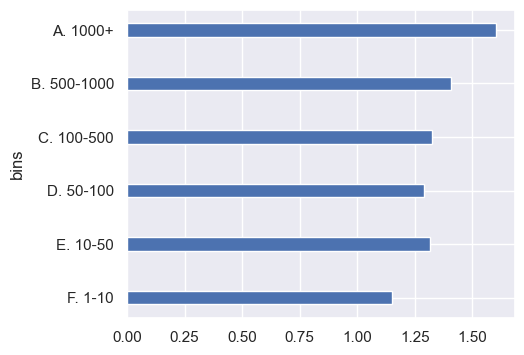

In [33]:
ax = platform_coverage.groupby('bins').agg(bin_mean=('platform_coverage','mean')).reset_index().plot.barh(x='bins', y='bin_mean', figsize=[5,4], width=0.25, legend=False)
ax.invert_yaxis()
plt.show()
plt.clf()

Restaurants are binned based on their number of stores and aggregated the results based on average platform coverage. The results suggest that smaller restaurant chains tend to be listed on less platforms, further analysis could be done to explore this relationship.